In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
def read_csv (path):
    train_data = pd.read_csv(path)
    return train_data

train_data =  read_csv('train.csv')
train_data_num = train_data.drop(columns=['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'])
train_data_text = train_data.drop(columns=['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'])
train_data_target = train_data['Survived']
corr_matrix = train_data_num.corr()

train_data_num.hist(figsize=(10, 10), bins=30)
plt.show()
print("Data frame splitting completed.")

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer

num_attributes = list(train_data_num)
text_attributes = list(train_data_text)

num_pipeline = Pipeline([  
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')), 
    ('scaler', StandardScaler())
])

text_pipeline = Pipeline([
    ('impute_text', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder())
])

pre_processor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_attributes),
        ('text', text_pipeline, text_attributes)
    ],
)

train_data_prepared = pre_processor.fit_transform(train_data)
print("Data preprocessing completed.")

Data preprocessing completed.


In [3]:
from sklearn.utils.class_weight import compute_class_weight 

class_weight = compute_class_weight(class_weight='balanced',classes = np.unique(train_data["Survived"]),y=train_data["Survived"])
class_weight_dict = dict(enumerate(class_weight))
print("Class weights computed")


Class weights computed


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve

sgd_clf = SGDClassifier(random_state=42,loss="hinge",penalty="l2",max_iter=1000, tol=1e-3,
                        alpha=0.00001, learning_rate="optimal", eta0=0.0, power_t=0.5,
                        early_stopping=True,)

svm_poly = SVC(kernel="rbf", C=1.0, gamma='scale', probability=True,random_state=42)

rf_clf = RandomForestClassifier(n_estimators=1, max_depth=None,
                                min_samples_split=2, min_samples_leaf=1,
                                max_features='sqrt', bootstrap=True)

dt_clf = DecisionTreeClassifier(random_state=42,max_depth=None, min_samples_split=2,criterion='log_loss',
                                splitter='best', min_samples_leaf=1,class_weight=class_weight_dict)


scoring = {'accuracy': 'accuracy','precision': make_scorer(precision_score, zero_division=0),
           'recall': make_scorer(recall_score, zero_division=0),'f1': make_scorer(f1_score, zero_division=0)}

scores = cross_validate(dt_clf,train_data_prepared,train_data_target,scoring=scoring,
                         cv=20,)
scores_list = pd.DataFrame(scores)
print(scores_list)
scores_list.mean(axis=0)        

[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


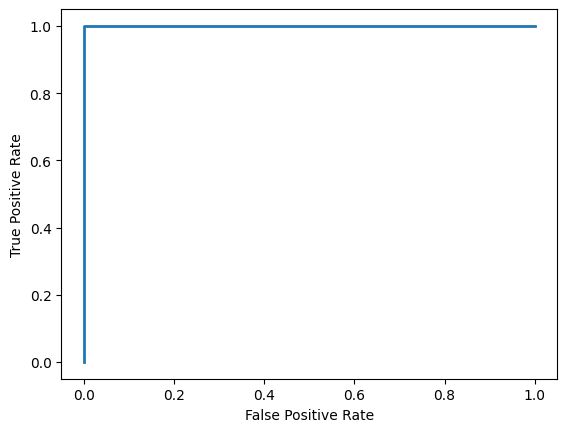

Model training and evaluation completed.


In [31]:
from sklearn.model_selection import cross_val_predict

prd_scores = cross_val_predict(dt_clf, train_data_prepared, train_data_target, cv=20,method='predict_proba')
print(prd_scores)
fpr, tpr, thresholds = roc_curve(train_data_target, prd_scores[:, 1])

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label, linewidth=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
plot_roc_curve(fpr, tpr, label='ROC Curve')
print("Model training and evaluation completed.")